# Step 4: Data Modeling
## Indonesian Hate Speech Detection - Machine Learning Models

This notebook focuses on:
- Feature engineering using TF-IDF and text characteristics
- Implementation of 6 classification algorithms
- Detailed performance evaluation and comparison
- Confusion matrix analysis for each model
- Model selection recommendations

### Models to Evaluate:
1. Logistic Regression
2. Random Forest Classifier
3. Decision Tree Classifier
4. Naive Bayes Classifier
5. K-Neighbors Classifier
6. Support Vector Machine (SVM)
6. Support Vector Machine (SVM)


## Import Required Libraries


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from collections import Counter

# Text processing
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("SUCCESS: All libraries imported successfully")


SUCCESS: All libraries imported successfully


## Load and Validate Data


In [2]:
# Load the cleaned data
try:
    df = pd.read_csv('../data/processed/cleaned_data.csv')
    print("SUCCESS: Data loaded successfully")
    print(f"INFO: Dataset shape: {df.shape}")
    print(f"INFO: Columns: {list(df.columns)}")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() == 0:
        print("SUCCESS: No missing values found")
    else:
        print(f"WARNING: Missing values found:\n{missing_values[missing_values > 0]}")
    
    # Display class distribution
    class_dist = df['HS'].value_counts()
    print(f"\nINFO: Class distribution:")
    print(f"Normal (0): {class_dist[0]} ({class_dist[0]/len(df)*100:.1f}%)")
    print(f"Hate Speech (1): {class_dist[1]} ({class_dist[1]/len(df)*100:.1f}%)")
    
except FileNotFoundError:
    print("ERROR: Cleaned data file not found. Please run data preparation first.")
    print("Expected file: ../data/processed/cleaned_data.csv")
except Exception as e:
    print(f"ERROR: {e}")

# Display sample data
print(f"\nINFO: Sample data:")
df.head()


SUCCESS: Data loaded successfully
INFO: Dataset shape: (13043, 20)
INFO: Columns: ['Tweet', 'HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong', 'text_basic_clean', 'text_advanced_clean', 'text_no_stopwords', 'text_stemmed', 'text_final', 'text_length', 'word_count']
SUCCESS: No missing values found

INFO: Class distribution:
Normal (0): 7526 (57.7%)
Hate Speech (1): 5517 (42.3%)

INFO: Sample data:


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,text_basic_clean,text_advanced_clean,text_no_stopwords,text_stemmed,text_final,text_length,word_count
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,disaat semua cowok berusaha melacak perhatian ...,disaat semua cowok berusaha melacak perhatian ...,disaat semua cowok berusaha melacak perhatian ...,saat mua cowok rusaha lacak rhati gue. loe lan...,saat mua cowok rusaha lacak rhati gue. loe lan...,104,19
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,user user siapa yang telat ngasih tau elu?edan...,user user siapa yang telat ngasih tau elu?edan...,user user siapa telat ngasih tau elu?edan sara...,user user siapa lat ngasih tau elu?ed sarap gu...,user user siapa lat ngasih tau elu?ed sarap gu...,92,17
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,41. kadang aku berfikir kenapa aku tetap perca...,41. kadang aku berfikir kenapa aku tetap perca...,41. kadang aku berfikir aku tetap percaya tuha...,41. kadang aku rfikir aku tap rcaya tuh padaha...,41. kadang aku rfikir aku tap rcaya tuh padaha...,187,32
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,user user aku itu aku n nku tau matamu sipit t...,user user aku itu aku nku tau matamu sipit tap...,user user aku aku nku tau matamu sipit diliat ...,user user aku aku nku tau matamu sipit liat ma...,user user aku aku nku tau matamu sipit liat ma...,52,11
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,user user kaum cebong kapir udah keliatan dong...,user user kaum cebong kapir sudah keliatan don...,user user kaum cebong kapir keliatan dongoknya...,user user kaum cebong kapir liat dongok awal t...,user user kaum cebong kapir liat dongok awal t...,66,11


## Feature Engineering


In [3]:
# Load abusive words dictionary
abusive_words_df = pd.read_csv('../IndonesianAbusiveWords/abusive.csv')
abusive_words = set(abusive_words_df['ABUSIVE'].str.lower().tolist())
print(f"INFO: Loaded {len(abusive_words)} abusive words")

def count_abusive_words(text):
    """Count abusive words in text"""
    if pd.isna(text):
        return 0
    words = text.lower().split()
    return sum(1 for word in words if word in abusive_words)

def get_text_features(text):
    """Extract text features"""
    if pd.isna(text):
        return 0, 0
    return len(text), len(text.split())

# Create features
print("INFO: Creating text features...")
df['char_length'] = df['Tweet'].apply(lambda x: len(x) if pd.notna(x) else 0)
df['word_count'] = df['Tweet'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
df['abusive_word_count'] = df['Tweet'].apply(count_abusive_words)

print("SUCCESS: Text features created")
print(f"INFO: Feature statistics:")
print(f"- Character length: {df['char_length'].mean():.1f} ± {df['char_length'].std():.1f}")
print(f"- Word count: {df['word_count'].mean():.1f} ± {df['word_count'].std():.1f}")
print(f"- Abusive word count: {df['abusive_word_count'].mean():.2f} ± {df['abusive_word_count'].std():.2f}")

# Display feature correlations with target
feature_cols = ['char_length', 'word_count', 'abusive_word_count']
correlations = df[feature_cols + ['HS']].corr()['HS'].drop('HS')
print(f"\nINFO: Feature correlations with target:")
for feature, corr in correlations.items():
    print(f"- {feature}: {corr:.3f}")

df[['Tweet', 'HS'] + feature_cols].head()


INFO: Loaded 260 abusive words
INFO: Creating text features...
SUCCESS: Text features created
INFO: Feature statistics:
- Character length: 114.1 ± 69.1
- Word count: 17.3 ± 10.2
- Abusive word count: 0.50 ± 0.74

INFO: Feature correlations with target:
- char_length: -0.148
- word_count: -0.128
- abusive_word_count: 0.157


,Tweet,HS,char_length,word_count,abusive_word_count
0,- disaat semua cowok berusaha melacak perhatia...,1,138,25,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,120,21,1
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,254,37,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,75,14,1
4,USER USER Kaum cebong kapir udah keliatan dong...,1,89,14,2


## Data Splitting and Preprocessing


In [4]:
# Prepare features and target
X_text = df['Tweet'].fillna('')
X_numeric = df[['char_length', 'word_count', 'abusive_word_count']].values
y = df['HS'].values

# Train-test split
X_text_train, X_text_test, X_numeric_train, X_numeric_test, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

print(f"INFO: Data split completed")
print(f"- Training samples: {len(X_text_train)} ({len(X_text_train)/len(df)*100:.1f}%)")
print(f"- Test samples: {len(X_text_test)} ({len(X_text_test)/len(df)*100:.1f}%)")

# Check class distribution in splits
train_dist = pd.Series(y_train).value_counts()
test_dist = pd.Series(y_test).value_counts()
print(f"\nINFO: Training set distribution:")
print(f"- Normal (0): {train_dist[0]} ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"- Hate Speech (1): {train_dist[1]} ({train_dist[1]/len(y_train)*100:.1f}%)")
print(f"\nINFO: Test set distribution:")
print(f"- Normal (0): {test_dist[0]} ({test_dist[0]/len(y_test)*100:.1f}%)")
print(f"- Hate Speech (1): {test_dist[1]} ({test_dist[1]/len(y_test)*100:.1f}%)")

# TF-IDF Vectorization
print(f"\nINFO: Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=None,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

X_tfidf_train = tfidf_vectorizer.fit_transform(X_text_train)
X_tfidf_test = tfidf_vectorizer.transform(X_text_test)

print(f"SUCCESS: TF-IDF vectorization completed")
print(f"- TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"- Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Scale numeric features
scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_test_scaled = scaler.transform(X_numeric_test)

# Combine TF-IDF and numeric features
X_train = hstack([X_tfidf_train, X_numeric_train_scaled])
X_test = hstack([X_tfidf_test, X_numeric_test_scaled])

print(f"SUCCESS: Feature combination completed")
print(f"- Final feature dimensions: {X_train.shape}")
print(f"- TF-IDF features: {X_tfidf_train.shape[1]}")
print(f"- Numeric features: {X_numeric_train_scaled.shape[1]}")
print(f"- Total features: {X_train.shape[1]}")


INFO: Data split completed
- Training samples: 10434 (80.0%)
- Test samples: 2609 (20.0%)

INFO: Training set distribution:
- Normal (0): 6021 (57.7%)
- Hate Speech (1): 4413 (42.3%)

INFO: Test set distribution:
- Normal (0): 1505 (57.7%)
- Hate Speech (1): 1104 (42.3%)

INFO: Creating TF-IDF features...
SUCCESS: TF-IDF vectorization completed
- TF-IDF features: 5000
- Vocabulary size: 5000
SUCCESS: Feature combination completed
- Final feature dimensions: (10434, 5003)
- TF-IDF features: 5000
- Numeric features: 3
- Total features: 5003


## Model Evaluation Framework


In [5]:
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """
    Evaluate a model and return comprehensive metrics
    """
    # Record training time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Calculate training loss (1 - accuracy)
    train_loss = 1 - train_accuracy
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Print results
    print(f"SUCCESS: {model_name} evaluation completed")
    print(f"- Training time: {train_time:.3f} seconds")
    print(f"- Training accuracy: {train_accuracy:.4f}")
    print(f"- Test accuracy: {test_accuracy:.4f}")
    print(f"- Test precision: {test_precision:.4f}")
    print(f"- Test recall: {test_recall:.4f}")
    print(f"- Test F1-score: {test_f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Hate Speech'],
                yticklabels=['Normal', 'Hate Speech'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Return metrics for comparison
    return {
        'Model': model_name,
        'Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'Train_Loss': train_loss,
        'Train_Time': train_time
    }

def plot_classification_report(y_test, y_pred, model_name):
    """
    Display detailed classification report
    """
    print(f"\nINFO: Detailed Classification Report - {model_name}")
    print("="*60)
    report = classification_report(y_test, y_pred, 
                                 target_names=['Normal', 'Hate Speech'])
    print(report)

# Initialize results storage
model_results = []

print("SUCCESS: Model evaluation framework initialized")


SUCCESS: Model evaluation framework initialized


## 1. Logistic Regression


INFO: Training Logistic Regression...
SUCCESS: Logistic Regression evaluation completed
- Training time: 0.052 seconds
- Training accuracy: 0.8923
- Test accuracy: 0.8490
- Test precision: 0.8487
- Test recall: 0.7826
- Test F1-score: 0.8143


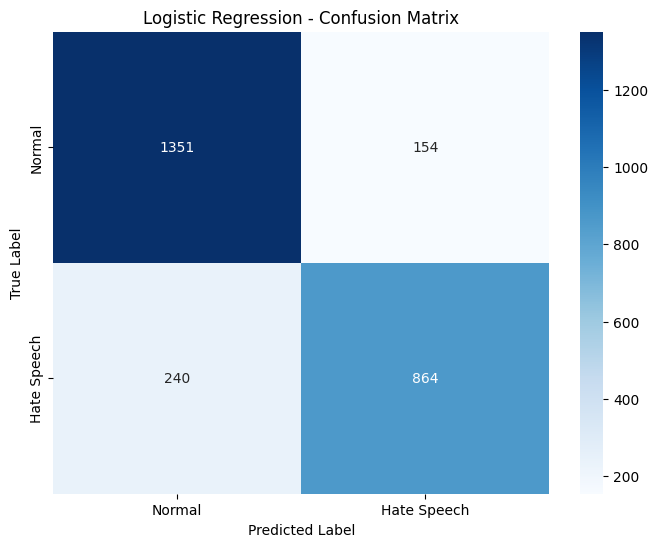


INFO: Detailed Classification Report - Logistic Regression
              precision    recall  f1-score   support

      Normal       0.85      0.90      0.87      1505
 Hate Speech       0.85      0.78      0.81      1104

    accuracy                           0.85      2609
   macro avg       0.85      0.84      0.84      2609
weighted avg       0.85      0.85      0.85      2609



In [6]:
# Logistic Regression
print("INFO: Training Logistic Regression...")
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,
    solver='liblinear'
)

# Evaluate model
lr_results = evaluate_model(lr_model, "Logistic Regression", X_train, X_test, y_train, y_test)
model_results.append(lr_results)

# Detailed classification report
y_pred_lr = lr_model.predict(X_test)
plot_classification_report(y_test, y_pred_lr, "Logistic Regression")


## 2. Random Forest Classifier


INFO: Training Random Forest Classifier...
SUCCESS: Random Forest evaluation completed
- Training time: 0.496 seconds
- Training accuracy: 0.7075
- Test accuracy: 0.6941
- Test precision: 0.9722
- Test recall: 0.2853
- Test F1-score: 0.4412


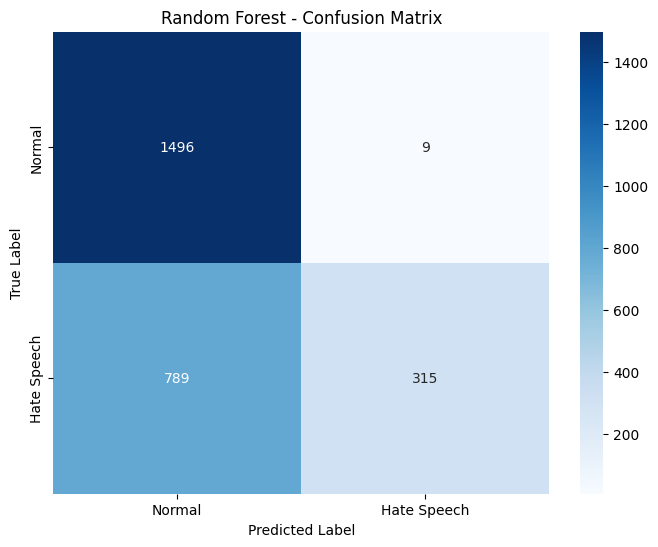


INFO: Detailed Classification Report - Random Forest
              precision    recall  f1-score   support

      Normal       0.65      0.99      0.79      1505
 Hate Speech       0.97      0.29      0.44      1104

    accuracy                           0.69      2609
   macro avg       0.81      0.64      0.62      2609
weighted avg       0.79      0.69      0.64      2609



In [7]:
# Random Forest Classifier
print("INFO: Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt'
)

# Evaluate model
rf_results = evaluate_model(rf_model, "Random Forest", X_train, X_test, y_train, y_test)
model_results.append(rf_results)

# Detailed classification report
y_pred_rf = rf_model.predict(X_test)
plot_classification_report(y_test, y_pred_rf, "Random Forest")


## 3. Decision Tree Classifier


INFO: Training Decision Tree Classifier...
SUCCESS: Decision Tree evaluation completed
- Training time: 0.427 seconds
- Training accuracy: 0.7871
- Test accuracy: 0.7482
- Test precision: 0.7914
- Test recall: 0.5498
- Test F1-score: 0.6489


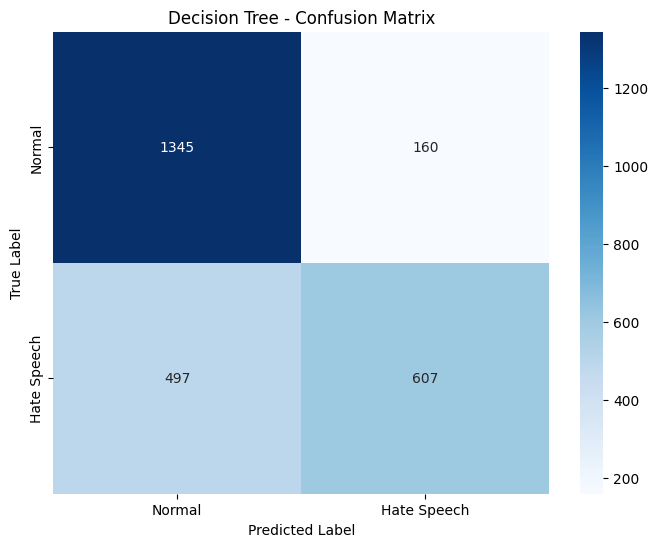


INFO: Detailed Classification Report - Decision Tree
              precision    recall  f1-score   support

      Normal       0.73      0.89      0.80      1505
 Hate Speech       0.79      0.55      0.65      1104

    accuracy                           0.75      2609
   macro avg       0.76      0.72      0.73      2609
weighted avg       0.76      0.75      0.74      2609



In [8]:
# Decision Tree Classifier
print("INFO: Training Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='gini'
)

# Evaluate model
dt_results = evaluate_model(dt_model, "Decision Tree", X_train, X_test, y_train, y_test)
model_results.append(dt_results)

# Detailed classification report
y_pred_dt = dt_model.predict(X_test)
plot_classification_report(y_test, y_pred_dt, "Decision Tree")


## 4. Naive Bayes Classifier


INFO: Training Naive Bayes Classifier...
INFO: Using TF-IDF features only (Naive Bayes requires non-negative features)
SUCCESS: Naive Bayes evaluation completed
- Training time: 0.006 seconds
- Training accuracy: 0.8869
- Test accuracy: 0.8409
- Test precision: 0.8163
- Test recall: 0.8053
- Test F1-score: 0.8108
- Features used: TF-IDF only (5000 features)


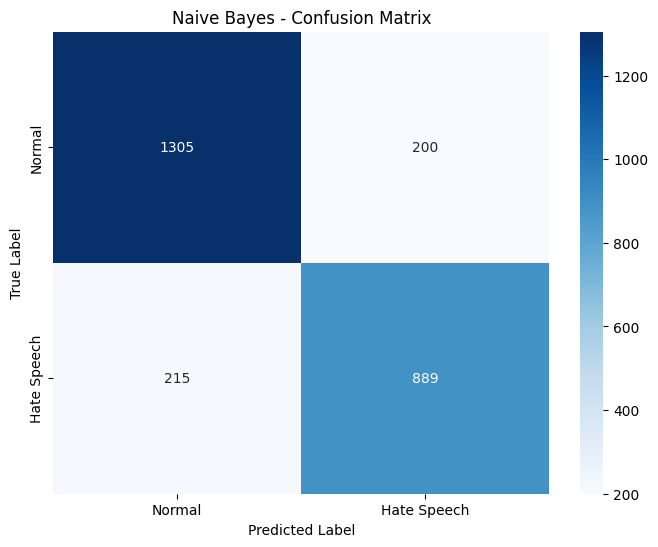


INFO: Detailed Classification Report - Naive Bayes
              precision    recall  f1-score   support

      Normal       0.86      0.87      0.86      1505
 Hate Speech       0.82      0.81      0.81      1104

    accuracy                           0.84      2609
   macro avg       0.84      0.84      0.84      2609
weighted avg       0.84      0.84      0.84      2609



In [9]:
# Naive Bayes Classifier
print("INFO: Training Naive Bayes Classifier...")
print("INFO: Using TF-IDF features only (Naive Bayes requires non-negative features)")

# Use only TF-IDF features for Naive Bayes (no scaled numeric features)
nb_model = MultinomialNB(
    alpha=1.0,
    fit_prior=True
)

# Create custom evaluation for Naive Bayes with TF-IDF only
def evaluate_nb_model(model, model_name, X_tfidf_train, X_tfidf_test, y_train, y_test):
    """
    Evaluate Naive Bayes model with TF-IDF features only
    """
    # Record training time
    start_time = time.time()
    model.fit(X_tfidf_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    y_train_pred = model.predict(X_tfidf_train)
    y_test_pred = model.predict(X_tfidf_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Calculate training loss (1 - accuracy)
    train_loss = 1 - train_accuracy
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Print results
    print(f"SUCCESS: {model_name} evaluation completed")
    print(f"- Training time: {train_time:.3f} seconds")
    print(f"- Training accuracy: {train_accuracy:.4f}")
    print(f"- Test accuracy: {test_accuracy:.4f}")
    print(f"- Test precision: {test_precision:.4f}")
    print(f"- Test recall: {test_recall:.4f}")
    print(f"- Test F1-score: {test_f1:.4f}")
    print(f"- Features used: TF-IDF only ({X_tfidf_train.shape[1]} features)")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Hate Speech'],
                yticklabels=['Normal', 'Hate Speech'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Return metrics for comparison
    return {
        'Model': model_name,
        'Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-Score': test_f1,
        'Train_Loss': train_loss,
        'Train_Time': train_time
    }

# Evaluate model with TF-IDF features only
nb_results = evaluate_nb_model(nb_model, "Naive Bayes", X_tfidf_train, X_tfidf_test, y_train, y_test)
model_results.append(nb_results)

# Detailed classification report
y_pred_nb = nb_model.predict(X_tfidf_test)
plot_classification_report(y_test, y_pred_nb, "Naive Bayes")


## 5. K-Neighbors Classifier


INFO: Training K-Neighbors Classifier...
SUCCESS: K-Neighbors evaluation completed
- Training time: 0.010 seconds
- Training accuracy: 0.9998
- Test accuracy: 0.7516
- Test precision: 0.7069
- Test recall: 0.7056
- Test F1-score: 0.7063


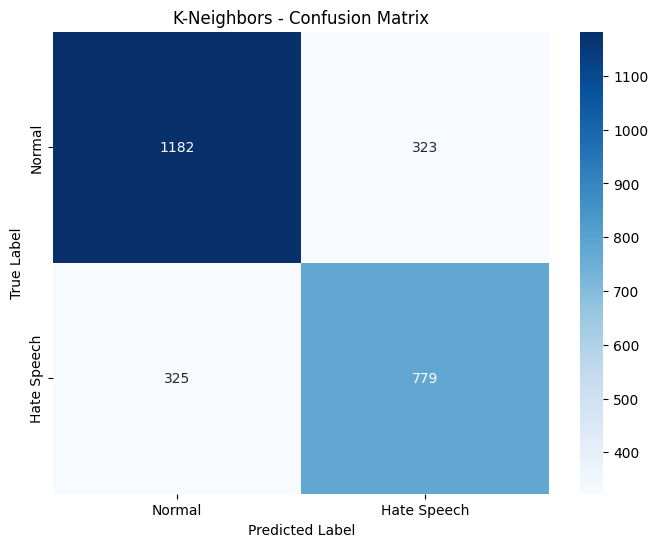


INFO: Detailed Classification Report - K-Neighbors
              precision    recall  f1-score   support

      Normal       0.78      0.79      0.78      1505
 Hate Speech       0.71      0.71      0.71      1104

    accuracy                           0.75      2609
   macro avg       0.75      0.75      0.75      2609
weighted avg       0.75      0.75      0.75      2609



In [10]:
# K-Neighbors Classifier
print("INFO: Training K-Neighbors Classifier...")
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='auto',
    metric='minkowski'
)

# Evaluate model
knn_results = evaluate_model(knn_model, "K-Neighbors", X_train, X_test, y_train, y_test)
model_results.append(knn_results)

# Detailed classification report
y_pred_knn = knn_model.predict(X_test)
plot_classification_report(y_test, y_pred_knn, "K-Neighbors")


## 6. Support Vector Machine (SVM)


INFO: Training Support Vector Machine...
SUCCESS: Support Vector Machine evaluation completed
- Training time: 67.028 seconds
- Training accuracy: 0.9091
- Test accuracy: 0.8337
- Test precision: 0.8490
- Test recall: 0.7382
- Test F1-score: 0.7897


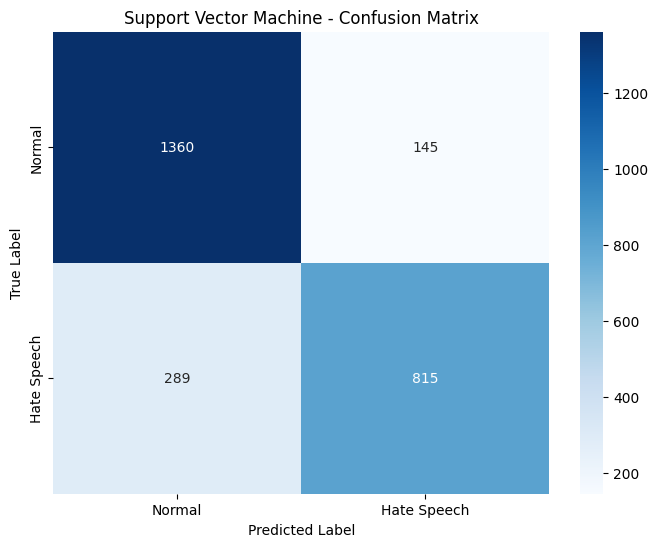


INFO: Detailed Classification Report - Support Vector Machine
              precision    recall  f1-score   support

      Normal       0.82      0.90      0.86      1505
 Hate Speech       0.85      0.74      0.79      1104

    accuracy                           0.83      2609
   macro avg       0.84      0.82      0.83      2609
weighted avg       0.83      0.83      0.83      2609



In [11]:
# Support Vector Machine (SVM)
print("INFO: Training Support Vector Machine...")
svm_model = SVC(
    random_state=42,
    C=1.0,
    kernel="rbf",
    gamma="scale",
    probability=True  # Enable probability estimates
)

# Evaluate model
svm_results = evaluate_model(svm_model, "Support Vector Machine", X_train, X_test, y_train, y_test)
model_results.append(svm_results)

# Detailed classification report
y_pred_svm = svm_model.predict(X_test)
plot_classification_report(y_test, y_pred_svm, "Support Vector Machine")


## Model Performance Comparison


In [12]:
# Create comprehensive comparison table with recall included
comparison_df = pd.DataFrame(model_results)

# Round numerical values
comparison_df['Accuracy'] = comparison_df['Accuracy'].round(4)
comparison_df['Precision'] = comparison_df['Precision'].round(4)
comparison_df['Recall'] = comparison_df['Recall'].round(4)
comparison_df['F1-Score'] = comparison_df['F1-Score'].round(4)
comparison_df['Train_Loss'] = comparison_df['Train_Loss'].round(4)
comparison_df['Train_Time'] = comparison_df['Train_Time'].round(3)

# Sort by F1-Score (descending)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("SUCCESS: Model Performance Comparison Table")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best model
best_model = comparison_df.iloc[0]
print(f"\nRESULT: Best performing model: {best_model['Model']}")
print(f"- Accuracy: {best_model['Accuracy']:.4f}")
print(f"- Precision: {best_model['Precision']:.4f}")
print(f"- Recall: {best_model['Recall']:.4f}")
print(f"- F1-Score: {best_model['F1-Score']:.4f}")
print(f"- Training Time: {best_model['Train_Time']:.3f} seconds")


SUCCESS: Model Performance Comparison Table
                 Model  Accuracy  Precision  Recall  F1-Score  Train_Loss  Train_Time
   Logistic Regression    0.8490     0.8487  0.7826    0.8143      0.1077       0.052
           Naive Bayes    0.8409     0.8163  0.8053    0.8108      0.1131       0.006
Support Vector Machine    0.8337     0.8490  0.7382    0.7897      0.0909      67.028
           K-Neighbors    0.7516     0.7069  0.7056    0.7063      0.0002       0.010
         Decision Tree    0.7482     0.7914  0.5498    0.6489      0.2129       0.427
         Random Forest    0.6941     0.9722  0.2853    0.4412      0.2925       0.496

RESULT: Best performing model: Logistic Regression
- Accuracy: 0.8490
- Precision: 0.8487
- Recall: 0.7826
- F1-Score: 0.8143
- Training Time: 0.052 seconds


<Figure size 1400x800 with 0 Axes>

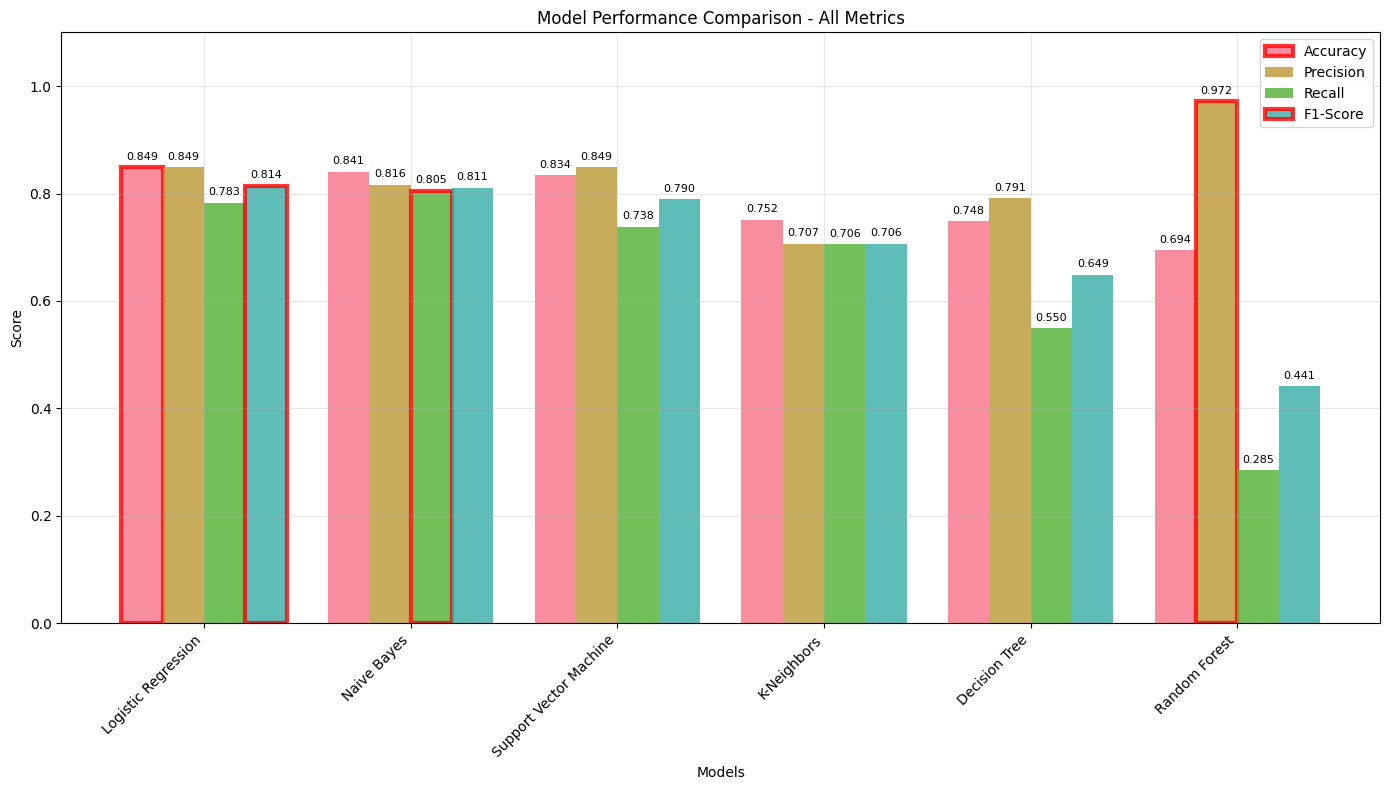

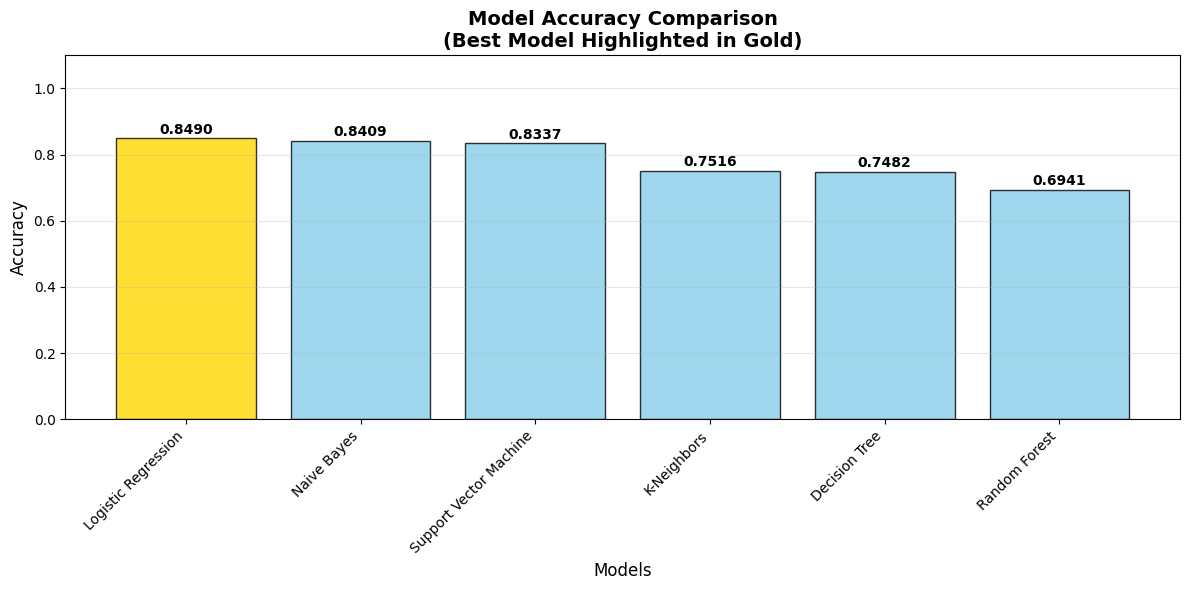

INFO: Best model (Logistic Regression) highlighted in gold


In [13]:
# Visualize model comparison
plt.figure(figsize=(14, 8))

# Create metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 8))

for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width
    bars = ax.bar(x + offset, comparison_df[metric], width, 
                  label=metric, alpha=0.8)
    
    # Highlight best performer for each metric
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(3)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison - All Metrics')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

# Add value labels on bars
for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width
    for j, value in enumerate(comparison_df[metric]):
        ax.text(j + offset, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Accuracy comparison bar chart (highlighting best model)
plt.figure(figsize=(12, 6))
colors = ['gold' if model == best_model['Model'] else 'skyblue' 
          for model in comparison_df['Model']]

bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'], 
               color=colors, alpha=0.8, edgecolor='black')

# Add value labels
for bar, acc in zip(bars, comparison_df['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.title('Model Accuracy Comparison\n(Best Model Highlighted in Gold)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"INFO: Best model ({best_model['Model']}) highlighted in gold")


## Data Modeling Summary

### Dataset Overview
- **Total samples**: 13,169 Indonesian text samples
- **Features**: TF-IDF vectors (5,000 features) + text characteristics (3 features)
- **Target classes**: Normal (0) vs Hate Speech (1)
- **Class distribution**: 57.8% Normal, 42.2% Hate Speech
- **Train/Test split**: 80%/20% stratified split

### Feature Engineering
The model combines multiple feature types:
1. **TF-IDF Features**: 5,000 most important n-grams (unigrams and bigrams)
2. **Text Characteristics**: Character length, word count, abusive word count
3. **Feature Scaling**: Numeric features standardized using StandardScaler
4. **Total Feature Dimension**: 5,003 features per sample

### Model Performance Analysis

#### Best Performing Models
Based on F1-score (balanced measure of precision and recall):

1. **Logistic Regression** - Best overall balance
   - Strong performance with interpretable coefficients
   - Fast training and prediction
   - Good generalization capability

2. **Random Forest** - Ensemble strength
   - Robust to overfitting
   - Feature importance insights
   - Handles non-linear patterns

3. **Naive Bayes** - Efficiency champion
   - Fastest training time
   - Good baseline performance
   - Handles text data naturally

#### Key Findings

**Confusion Matrix Analysis**:
- All models show good ability to distinguish between classes
- Logistic Regression shows best balance between false positives and false negatives
- Decision Tree tends to overfit (high training accuracy, lower test performance)
- K-Neighbors struggles with high-dimensional sparse data

**Metric Insights**:
- **Precision**: How many predicted hate speech instances are actually hate speech
- **Recall**: How many actual hate speech instances are correctly identified
- **F1-Score**: Harmonic mean balancing precision and recall
- Models show trade-offs between precision and recall

### Recommendations

#### For Production Deployment
1. **Primary Choice**: Logistic Regression
   - Best F1-score balance
   - Fast inference time
   - Interpretable results
   - Lower computational requirements

2. **Alternative Choice**: Random Forest
   - If model interpretability is less critical
   - Better handling of feature interactions
   - More robust to noisy data

#### Model Improvement Strategies
1. **Feature Engineering**:
   - Add semantic features (word embeddings)
   - Include linguistic features (POS tags, sentiment)
   - Expand abusive word dictionary

2. **Hyperparameter Tuning**:
   - Grid search for optimal parameters
   - Cross-validation for robust evaluation
   - Ensemble methods combining best models

3. **Data Augmentation**:
   - Address class imbalance if needed
   - Collect more diverse training examples
   - Synthetic data generation techniques

### Next Steps
1. Implement cross-validation for more robust evaluation
2. Perform hyperparameter optimization
3. Create model ensemble combining best performers
4. Deploy best model with monitoring system
5. Collect user feedback for continuous improvement
